In [6]:
# directories
datasetDir = "D://sd_dataset_new/"
datasetName = "2018-08-10_01-55-16"
rawDir = "raw/"
labDir = "gt/"

# timepoint
t = 2

# tile list
l = [5,8,11,14,17,20,23]

In [59]:
import tifffile


ll = l[0]

#
height = range(40)
h = height[0]

# template
fullPathRaw = datasetDir + rawDir + datasetName+"_P"+str(ll) + "_"+str(h)+"_raw.tif"

X = []
Y = []
for t in range(0,65,10):
    for i in range(1,9):
        for j in range(1,60,1):
#             if (t!=12):
#                 suff=''
#                 if (t<10):
#                     suff='0'
                print((t,i,j), end="\r")
                fullPathRaw = datasetDir + "\\raw\\" + datasetName + "_"+str(t)+"_"+str(i)+"_"+str(j)+"_raw.tif"
                fullPathLabels = datasetDir + "\\gt\\" + datasetName + "_"+str(t)+"_"+str(i)+"_"+str(j)+"_gt.tif"
                X.append(tifffile.imread(fullPathRaw))
                Y.append(tifffile.imread(fullPathLabels))
            

In [60]:
import numpy as np
X = np.array(X)
Y = np.array(Y)

In [61]:
X.shape, Y.shape

((3304,), (3304,))

In [62]:
X[70].shape

(1023, 660)

In [8]:
# dump
import pickle
fname = "./pickles/sd_dataset_t_"+str(range(3,20,1))+"_tiles_"+str(l)+"_h_40_not_normalized"

f = open(fname,'wb')
pickle.dump((X,Y),f, protocol=4)
f.close()

In [5]:
import pickle
fname = "./pickles/sd_dataset_t_"+str(range(3,20,1))+"_tiles_"+str(l)+"_h_40_not_normalized"

f = open(fname,'rb')
X,Y = pickle.load(f)
f.close()

In [14]:
from unet.modules.functions import normalizeWithLimits

Using TensorFlow backend.
C:\Users\myersadmin\AppData\Roaming\Python\Python35\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [63]:
import numpy as np
XN = [np.zeros(X.shape)]
for i in range(X.shape[0]):
    print(i, end="\r")
    XN.append(normalizeWithLimits(X[i]))


In [64]:
XN = np.array(XN[1:])

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=10,10


(<matplotlib.image.AxesImage at 0xaaba7f0>,
 <matplotlib.colorbar.Colorbar at 0xab04ac8>)

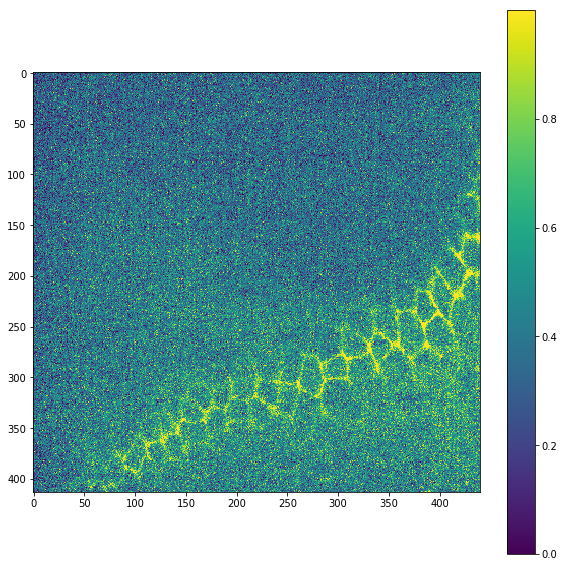

In [66]:
plt.imshow(XN[25]),plt.colorbar()

In [67]:
import tensorflow as tf
from keras.backend import tensorflow_backend

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.30)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tensorflow_backend.set_session(sess)

In [68]:
testCutoff = 1500
X_tr = XN[:-testCutoff]; Y_tr = Y[:-testCutoff]
X_te = XN[-testCutoff:]; Y_te = Y[-testCutoff:]

In [69]:
X_tr.shape, Y_tr.shape, X_te.shape, Y_te.shape

((1804,), (1804,), (1500,), (1500,))

In [70]:
XN[0].shape

(413, 440)

In [71]:
delta=128
i=0; j=0
X_cr = np.zeros((1,128,128))
Y_cr = np.zeros((1,128,128))

z = X.shape[0]


for k in range(z):
    for i in range(0, X_tr[k].shape[0]-delta, delta):
        for j in range(0, X_tr[k].shape[1]-delta, delta):
            print((k,i,i+delta, j, j+delta), end="\r")
            a = X_tr[k][i:i+delta, j:j+delta][np.newaxis,...]
#             print(a.shape)
#             print(X_cr.shape)
            X_cr = np.concatenate((X_cr,a))
#             print("a" + str(a.shape))
            b = Y_tr[k][i:i+delta, j:j+delta][np.newaxis,...]
            Y_cr = np.concatenate((Y_cr, b))
#             print("b" + str(b.shape))

KeyboardInterrupt: 

In [57]:
X_tr[354].shape

(1023, 123)

In [15]:
a.shape

(1968, 128, 128)

In [72]:
X_cr.shape, Y_cr.shape

((2392, 128, 128), (2391, 128, 128))

In [73]:
X_cr = X_cr[1:-1,:,:]
Y_cr = Y_cr[1:,:,:]

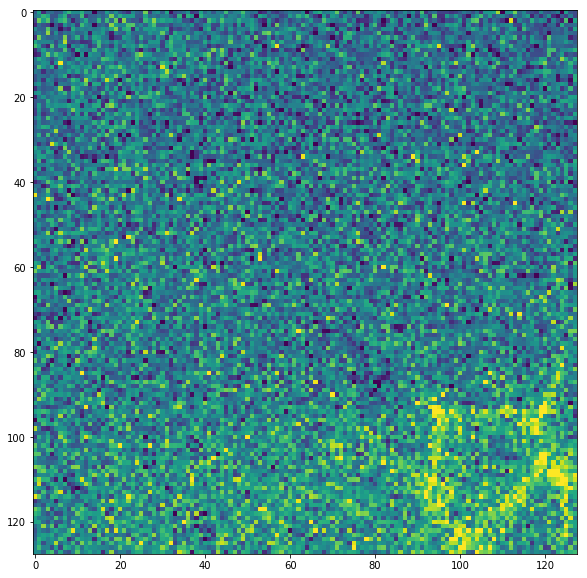

In [110]:
ind = 256
plt.imshow(X_cr[ind])

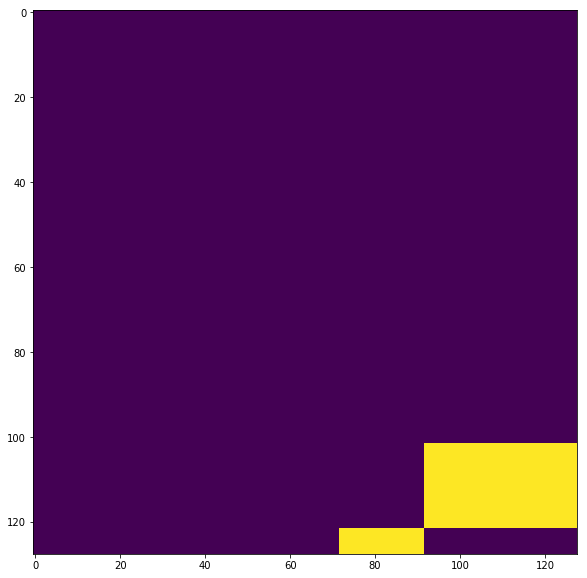

In [111]:
plt.imshow(Y_cr[ind])

In [112]:
st = np.concatenate((X_cr[...,np.newaxis],Y_cr[...,np.newaxis]),axis=3)
np.random.shuffle(st)
X_cr = st[:,:,:,0]
Y_cr = st[:,:,:,1]

In [113]:
from importlib import reload
reload(unet.modules.net)

NameError: name 'unet' is not defined

In [114]:
import unet.modules.net
model = unet.modules.net.build_unet((None,None,1), depth=2, nFilterBase=16, kernelSize=5, nConvPerLayer=2,regLambda=0)

In [116]:
from keras.optimizers import Adam
from unet.modules.functions import my_binary_crossentropy
model.compile(optimizer=Adam(lr=0.001), loss=my_binary_crossentropy(weights=(1.0,40.0)))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [117]:
model.fit(X_cr[...,np.newaxis],Y_cr[..., np.newaxis], epochs=20, batch_size=50, validation_split=.1)

Train on 2151 samples, validate on 239 samples
Epoch 1/20
2151/2151 [==============================] - 13s - loss: 0.6137 - val_loss: 0.9331
Epoch 2/20
2151/2151 [==============================] - 8s - loss: 0.3980 - val_loss: 1.4453
Epoch 3/20
2151/2151 [==============================] - 8s - loss: 0.3343 - val_loss: 1.0773
Epoch 4/20
2151/2151 [==============================] - 8s - loss: 0.2932 - val_loss: 1.0736
Epoch 5/20
2151/2151 [==============================] - 8s - loss: 0.2618 - val_loss: 0.8271
Epoch 6/20
2151/2151 [==============================] - 9s - loss: 0.2481 - val_loss: 0.6398
Epoch 7/20
2151/2151 [==============================] - 9s - loss: 0.2397 - val_loss: 0.3598
Epoch 8/20
2151/2151 [==============================] - 9s - loss: 0.3373 - val_loss: 3.4477
Epoch 9/20
2151/2151 [==============================] - 9s - loss: 0.2638 - val_loss: 0.4278
Epoch 10/20
2151/2151 [==============================] - 9s - loss: 0.3384 - val_loss: 0.4713
Epoch 11/20
2151/2151

In [118]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 1) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 16 416         input[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 16 64          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 16 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

(<matplotlib.image.AxesImage at 0x252bfdd8>,
 <matplotlib.colorbar.Colorbar at 0x25311b00>)

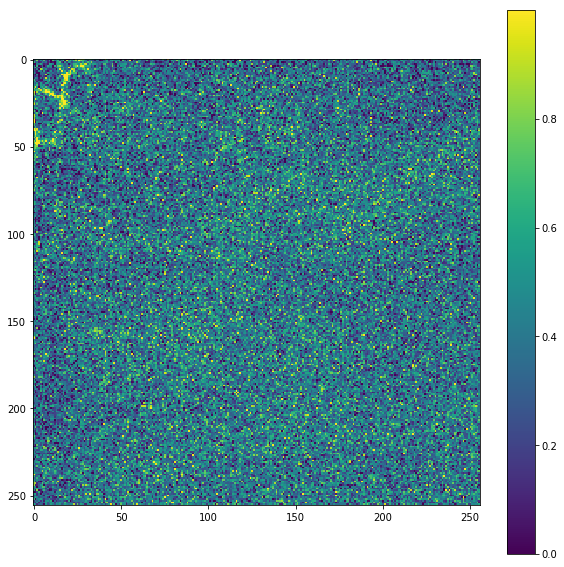

In [196]:
i = 194
plt.rcParams['figure.figsize']=10,10
testFrame = X_te[i][:256,:256]
plt.imshow(testFrame, interpolation="None"), plt.colorbar()

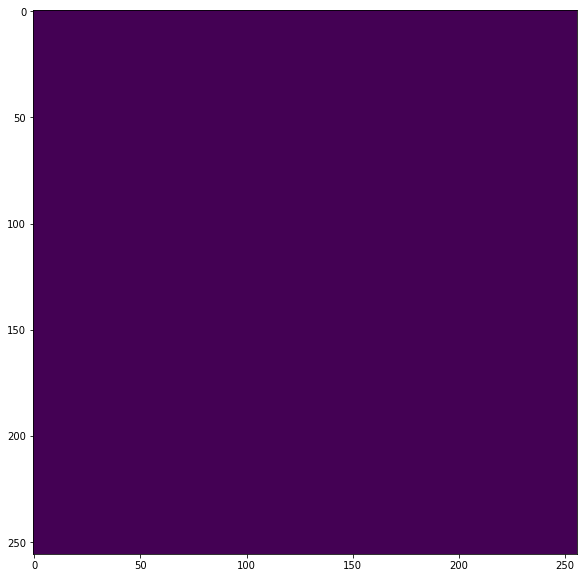

In [198]:
testFrameY = Y_te[i][:256,:256]
plt.imshow(testFrameY)

In [199]:
pr = model.predict(testFrame[np.newaxis,...,np.newaxis])

(<matplotlib.image.AxesImage at 0x256c9a58>,
 <matplotlib.colorbar.Colorbar at 0x2571a198>)

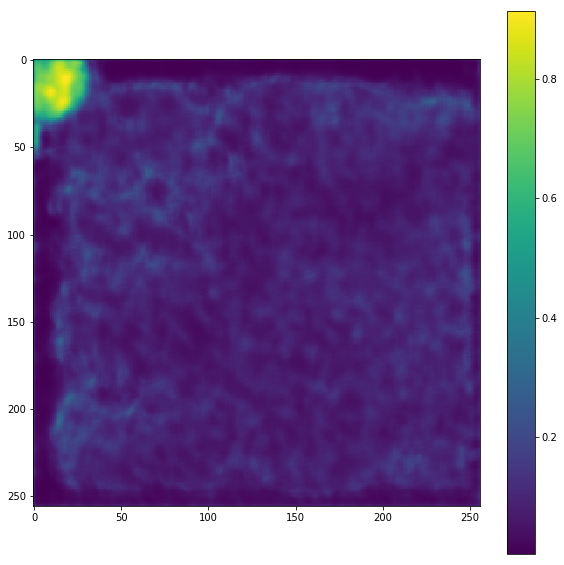

In [200]:
plt.imshow(pr[0,:,:,0]), plt.colorbar()

In [71]:
plt.imshow(prOld[0,:,:,0])

NameError: name 'prOld' is not defined

In [202]:
# saving model
modelName = "../resources/models/unet_for_sample_detection_20_kernel_5_5_epochs_20_lrdec_001_depth_2_diff_tr_reg_0_p_1"

json_string = model.to_json()

import json
with open(modelName+"_json", 'w') as outfile:
    json.dump(json_string, outfile)
    
# saving weights
model.save_weights(modelName+'_weights.h5')

### Loading the saved model

In [7]:
import json, unet.modules.net as net

modelName = "./unet_for_sample_detection_7_kernel_5_5_epochs_20_lrdec_001_depth_2_diff_tr_reg_0_p_1"

modelLoaded = net.build_unet()


TypeError: build_unet() missing 1 required positional argument: 'input_shape'

In [3]:
from keras.models import model_from_json
modelLoaded = model_from_json(json_string_loaded)

Using TensorFlow backend.
C:\Users\myersadmin\AppData\Roaming\Python\Python35\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ValueError: Unknown regularizer: RegVar

In [ ]:
w

In [103]:
import os
def readTile(pathToDataset="../resources/img/nice_full_wing/B=0/T=0/", tileNum=0, channelNum=1):
  """Reads a stack corresponding to a certain tile and channel in a dataset. Follows the ZenBlue naming conventions."""
  path = pathToDataset+"S="+str(tileNum)+"/C="+str(channelNum)+"/"
  arr = np.array([tifffile.imread(path+i) for i in os.listdir(path) if i.endswith(".tif")])
  return arr

In [72]:
import tifffile
q = tifffile.imread("D:/savedStacks/2018-08-10_01-55-16/0/1_1040_1024_60.tif")

In [104]:
tileNum = 8
q = readTile(pathToDataset="../SampleDetection/resources/img/nice_full_wing/B=0/T=0/", tileNum=tileNum,channelNum=3)
# q = X_te[0]
# q = tifffile.imread("./stack_1.tif")

(<matplotlib.image.AxesImage at 0x1fb611d0>,
 <matplotlib.colorbar.Colorbar at 0x1fbad9b0>)

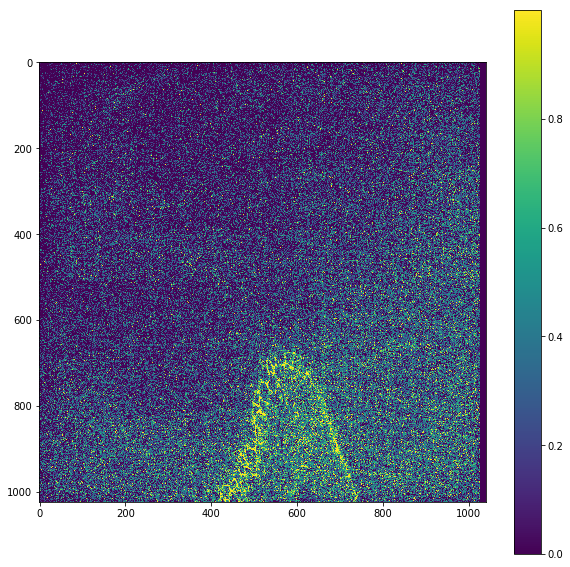

In [91]:
ind =20
qf = normalizeWithLimits(q[ind,:,:], upLim=99, loLim=33)
plt.imshow(qf), plt.colorbar()

In [92]:
qq = model.predict(qf[np.newaxis, ..., np.newaxis])

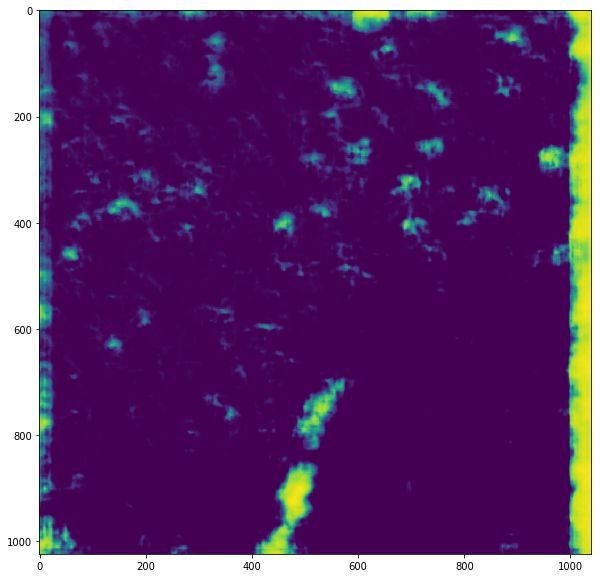

In [93]:
plt.imshow(qq[0,:,:,0])

In [117]:
z = q[10][np.newaxis, ..., np.newaxis]

In [118]:
z.T.shape

(1, 692, 520, 1)

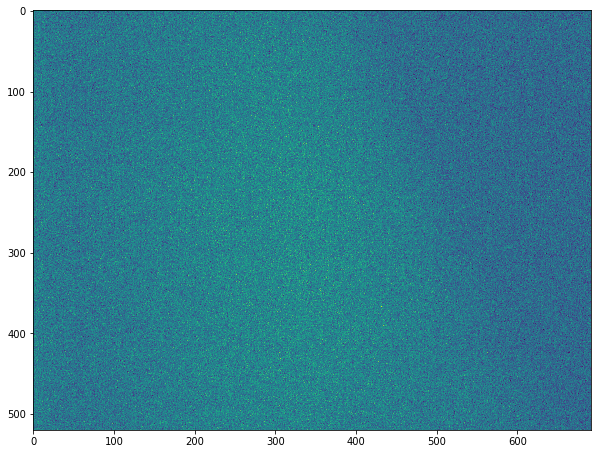

In [119]:
plt.imshow(z[0,:,:,0])

In [625]:
# with open("unet_for_sample_detection_2_kernel_5_5_epochs_20_lrdec_001_json", 'r') as infile:
#     json_string_loaded = json.load(infile)


# from keras.models import model_from_json
# modelLoaded = model_from_json(json_string_loaded)

In [1135]:
modelLoaded = net.build_model_unet((None,None,1), arch="2_16_5_5", coeff=0)

In [1139]:
modelLoaded.load_weights("./unet_for_sample_detection_2_kernel_5_5_epochs_40_lrdec_001_weights.h5")

In [530]:
prOld = modelLoaded.predict(testFrame[np.newaxis, ..., np.newaxis])

In [622]:
import seaborn as sns
sns.set()
sns.set_style('whitegrid', {"axes.grid":False})

In [873]:
qn = np.zeros(q.shape)


z,x,y = q.shape
profNet = np.zeros(z)
predStack = np.zeros((q.shape[0], q.shape[1], q.shape[2]-4))
for k in range(z):
    prediction = model.predict(normalizeWithLimits(q[k,:,0:688])[np.newaxis, ..., np.newaxis])[0,:,:,0]
    profNet[k] = np.mean(prediction)
    predStack[k] = prediction

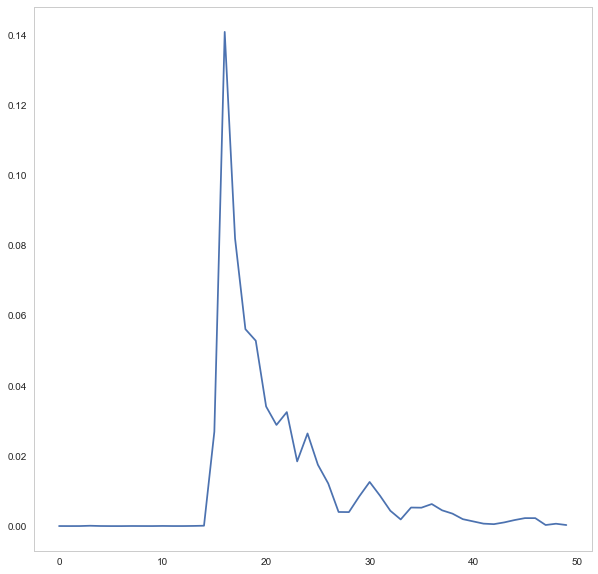

In [874]:
plt.plot(profNet)

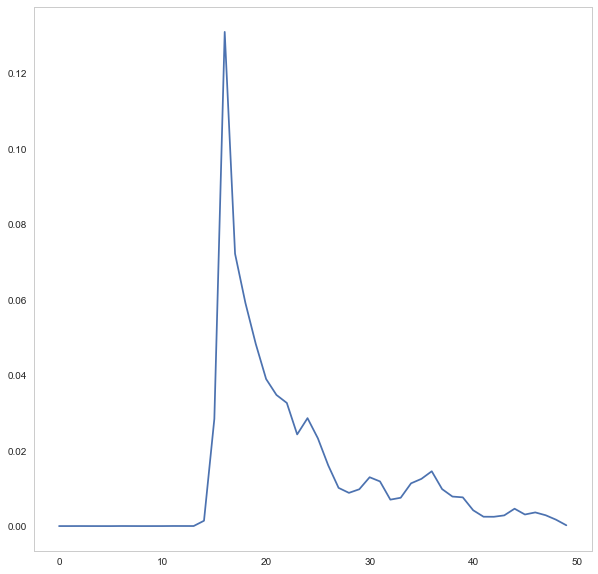

In [767]:
plt.plot(profNet)
plt.savefig("net_"+str(tileNum)+".png")

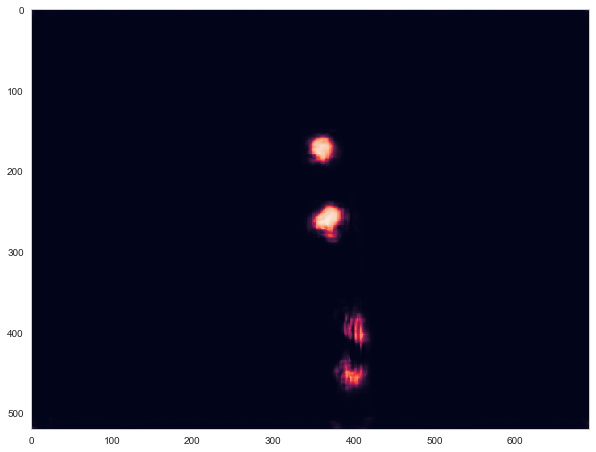

In [738]:
plt.imshow(predStack[35])

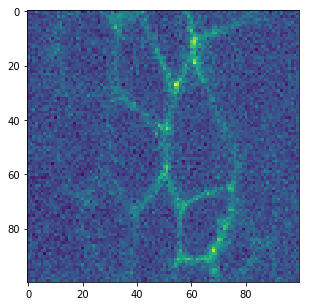

In [547]:
plt.imshow(q[18, 400:500,200:300])

In [549]:
15*400/(692*520)

0.016674077367718986

In [554]:
def getVarianceProfile(stack):
  """Variance z profile of a stack. First dim is supposed to be depth."""
  depth = stack.shape[0]
  var_prof= np.zeros(depth)

  for i in range(depth):
      var_prof[i] = np.var(stack[i,:,:])
  return np.array(var_prof)

In [564]:
from scipy.fftpack import dct

def dct2d(img, norm=None):
  return dct(dct(img, axis=0, norm=norm),axis=1, norm=norm)

def cropToLeftTop(img):
  x,y = img.shape
  return np.array(img[0:x//2, 0:y//2])

def DCTS(img):
  norm = np.linalg.norm(img)
  return -np.sum(np.abs(img/norm)*np.log2(np.abs(img)/norm))

def getDCTSProfile(stack):
  depth = stack.shape[0]
  dcts_prof= np.zeros(depth)

  for i in range(depth):
      dcts_prof[i] = DCTS(cropToLeftTop(dct2d(stack[i,:,:])))
  return np.array(dcts_prof)

In [739]:
# qn = np.zeros(q.shape)


z,x,y = q.shape
profVar = getVarianceProfile(q)
profDCTS2D = getDCTSProfile(q)



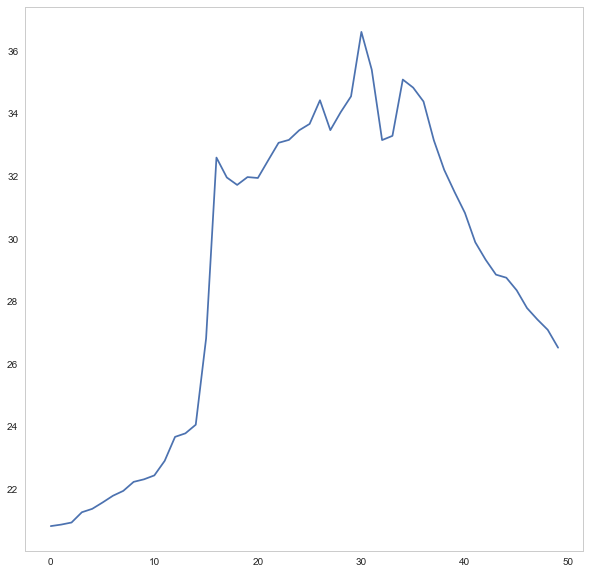

In [768]:
plt.plot(profVar)
plt.savefig("var_"+str(tileNum)+".png")

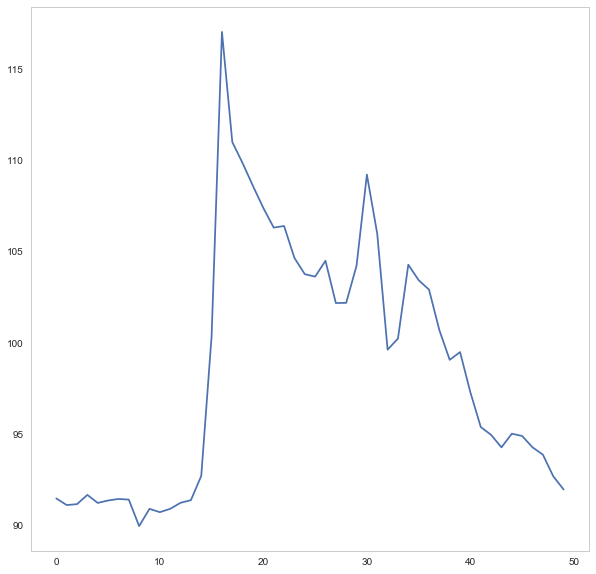

In [769]:
plt.plot(profDCTS2D)
plt.savefig("DCTS2D_"+str(tileNum)+".png")

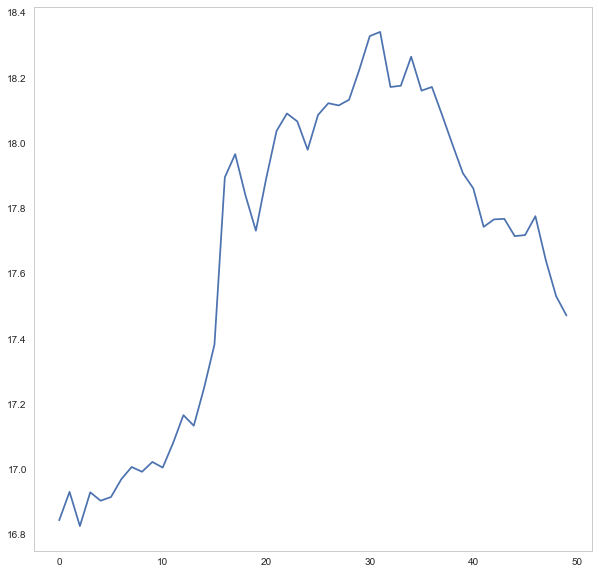

In [643]:
plt.plot(profVar)

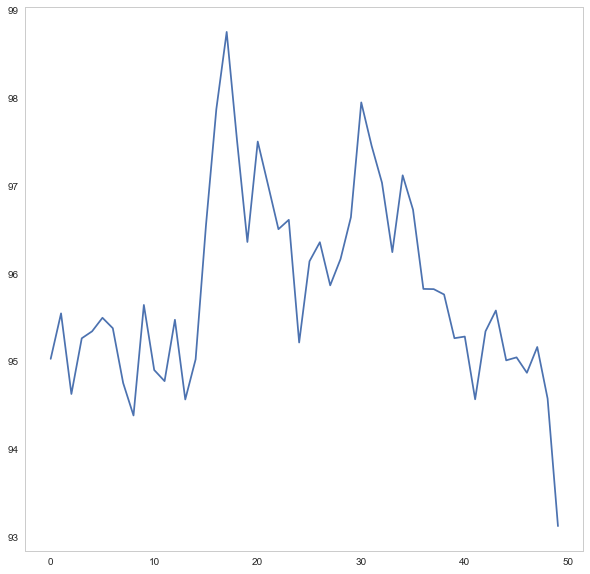

In [644]:
plt.plot(profDCTS2D)

In [ ]:
K.